In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Make matplotlib render retina-quality charts
import seaborn as sns
from IPython.display import display

## 1. First look at the data

In [2]:
data = pd.read_csv('dataset.csv')

# Some values in TotalCharges were not able to load as numeric.
# I manually handle it by replacing them by the product of tenure and monthly charges.
data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
data.loc[data.TotalCharges.isnull(), 'TotalCharges'] = data.tenure * data.MonthlyCharges

print("Original dataset sample:")
display(data.head(5))
display(data.info())

Original dataset sample:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

### What do I notice immediately:
- The quality of data is really good. It was clear from Kaggle's preview, and now confirmed. There are no missing values, and all columns have meaningful sense and values.
- "customerID" column contains unique IDs (confirmed at Kaggle's preview), so we can delete it.
- Since a lot of feature are multi-level categorical features, we will need to do a lot of encoding.

## 2. Feature-by feature analysis
**Important**: if I decide to drop or encode some features, I will consecutively add their names to special lists initialized in the cell below, and delete/encode them in 1 line in the end of the feature-by-feature analysis.

In [3]:
columns_to_delete = [] # Here we will accumulate names of columns for deletion
columns_to_encode = [] # Here we will accumulate names of columns for encoding

def plot_crosstab_and_value_counts_againts_target(categorical_feature):
    """This function takes a name of a categorical feature as string,
    and plots crosstab and value_counts of it versus the target."""
    
    print("Count of values: {} versus Churn:".format(categorical_feature))
    display(pd.crosstab(data.Churn, data[categorical_feature], margins=True).style.background_gradient(cmap='summer_r'))
    print("Average churn rate for each {}:".format(categorical_feature))
    display(data.groupby(categorical_feature)['Churn'].mean().sort_values(ascending=False))
    
def display_correlation_with_binned_version(numerical_feature):
    """This function takes a name of a numerical feature as string,
    and plots crosstab and value_counts of it 5-binned version versus the target."""
    
    feature_binned_name = numerical_feature + "_binned"
    data[feature_binned_name] = pd.cut(data[numerical_feature], bins = 5)
    plot_crosstab_and_value_counts_againts_target(feature_binned_name)
    data.drop(feature_binned_name, axis = 1, inplace = True)

### (Target) Churn
This column is binary, and contains string values "Yes" and "No". Let's encode it to boolean at the beginning, because it will allow us to calculate average churn rates per different dimensions of data.

In [4]:
data.Churn = data.Churn.map({"Yes": 1, "No": 0})

### (1/20) customerID
As was indicate above, this feature can be deleted.

In [5]:
columns_to_delete.append("customerID")

### (2/20) gender – whether the customer is a male or a female

In [6]:
plot_crosstab_and_value_counts_againts_target('gender')
columns_to_delete.append("gender")

Count of values: gender versus Churn:


gender,Female,Male,All
Churn,,,
0,2549,2625,5174
1,939,930,1869
All,3488,3555,7043


Average churn rate for each gender:


gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64

**Decision**: this feature alone seems to have no correlation with the target. **Don't include** in the models.

### (3/20) SeniorCitizen – whether the customer is a senior citizen or not (1, 0)

In [7]:
plot_crosstab_and_value_counts_againts_target('SeniorCitizen')

Count of values: SeniorCitizen versus Churn:


SeniorCitizen,0,1,All
Churn,,,
0,4508,666,5174
1,1393,476,1869
All,5901,1142,7043


Average churn rate for each SeniorCitizen:


SeniorCitizen
1    0.416813
0    0.236062
Name: Churn, dtype: float64

**Decision**: for both senior and non-senior citizens, the churn rate is <50%. However, for senior citizens it is 2 times higher than for non-senior! We will include this feature in the model. **Include** in the models.

### (4/20) Partner – whether the customer has a partner or not

In [8]:
plot_crosstab_and_value_counts_againts_target('Partner')
columns_to_encode.append('Partner')

Count of values: Partner versus Churn:


Partner,No,Yes,All
Churn,,,
0,2441,2733,5174
1,1200,669,1869
All,3641,3402,7043


Average churn rate for each Partner:


Partner
No     0.329580
Yes    0.196649
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (5/20) Dependents – whether the customer has dependents or not (Yes, No)

In [9]:
plot_crosstab_and_value_counts_againts_target('Dependents')
columns_to_encode.append('Dependents')

Count of values: Dependents versus Churn:


Dependents,No,Yes,All
Churn,,,
0,3390,1784,5174
1,1543,326,1869
All,4933,2110,7043


Average churn rate for each Dependents:


Dependents
No     0.312791
Yes    0.154502
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (6/20) tenure – number of months the customer has stayed with the company

In [10]:
display_correlation_with_binned_version('tenure')

Count of values: tenure_binned versus Churn:


tenure_binned,"(-0.072, 14.4]","(14.4, 28.8]","(28.8, 43.2]","(43.2, 57.6]","(57.6, 72.0]",All
Churn,,,,,,
0,1272,831,774,805,1492,5174
1,1099,295,215,142,118,1869
All,2371,1126,989,947,1610,7043


Average churn rate for each tenure_binned:


tenure_binned
(-0.072, 14.4]    0.463518
(14.4, 28.8]      0.261989
(28.8, 43.2]      0.217391
(43.2, 57.6]      0.149947
(57.6, 72.0]      0.073292
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see clear negative correlation between the tenure and the churn rate.

### (7/20) PhoneService – whether the customer has a phone service or not (Yes, No)

In [11]:
plot_crosstab_and_value_counts_againts_target('PhoneService')
columns_to_delete.append('PhoneService')

Count of values: PhoneService versus Churn:


PhoneService,No,Yes,All
Churn,,,
0,512,4662,5174
1,170,1699,1869
All,682,6361,7043


Average churn rate for each PhoneService:


PhoneService
Yes    0.267096
No     0.249267
Name: Churn, dtype: float64

**Decision**: this feature alone seems to have no correlation with the target. **Don't include** in the models.

### (8/20) MultipleLines – whether the customer has multiple lines or not (Yes, No, No phone service)

In [12]:
plot_crosstab_and_value_counts_againts_target('MultipleLines')
columns_to_delete.append('MultipleLines')

Count of values: MultipleLines versus Churn:


MultipleLines,No,No phone service,Yes,All
Churn,,,,
0,2541,512,2121,5174
1,849,170,850,1869
All,3390,682,2971,7043


Average churn rate for each MultipleLines:


MultipleLines
Yes                 0.286099
No                  0.250442
No phone service    0.249267
Name: Churn, dtype: float64

**Decision**: this feature alone seems to have no correlation with the target. **Don't include** in the models.

### (9/20) InternetService – customer’s internet service provider (DSL, Fiber optic, No)

In [13]:
plot_crosstab_and_value_counts_againts_target('InternetService')
columns_to_encode.append('InternetService')

Count of values: InternetService versus Churn:


InternetService,DSL,Fiber optic,No,All
Churn,,,,
0,1962,1799,1413,5174
1,459,1297,113,1869
All,2421,3096,1526,7043


Average churn rate for each InternetService:


InternetService
Fiber optic    0.418928
DSL            0.189591
No             0.074050
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (10/20) OnlineSecurity – whether the customer has online security or not (Yes, No, No internet service)

In [14]:
plot_crosstab_and_value_counts_againts_target('OnlineSecurity')
columns_to_encode.append('OnlineSecurity')

Count of values: OnlineSecurity versus Churn:


OnlineSecurity,No,No internet service,Yes,All
Churn,,,,
0,2037,1413,1724,5174
1,1461,113,295,1869
All,3498,1526,2019,7043


Average churn rate for each OnlineSecurity:


OnlineSecurity
No                     0.417667
Yes                    0.146112
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (11/20) OnlineBackup – whether the customer has online backup or not (Yes, No, No internet service)

In [15]:
plot_crosstab_and_value_counts_againts_target('OnlineBackup')
columns_to_encode.append('OnlineBackup')

Count of values: OnlineBackup versus Churn:


OnlineBackup,No,No internet service,Yes,All
Churn,,,,
0,1855,1413,1906,5174
1,1233,113,523,1869
All,3088,1526,2429,7043


Average churn rate for each OnlineBackup:


OnlineBackup
No                     0.399288
Yes                    0.215315
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (12/20) DeviceProtection – whether the customer has device protection or not (Yes, No, No internet service)

In [16]:
plot_crosstab_and_value_counts_againts_target('DeviceProtection')
columns_to_encode.append('DeviceProtection')

Count of values: DeviceProtection versus Churn:


DeviceProtection,No,No internet service,Yes,All
Churn,,,,
0,1884,1413,1877,5174
1,1211,113,545,1869
All,3095,1526,2422,7043


Average churn rate for each DeviceProtection:


DeviceProtection
No                     0.391276
Yes                    0.225021
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (13/20) TechSupport – whether the customer has tech support or not (Yes, No, No internet service)

In [17]:
plot_crosstab_and_value_counts_againts_target('TechSupport')
columns_to_encode.append('TechSupport')

Count of values: TechSupport versus Churn:


TechSupport,No,No internet service,Yes,All
Churn,,,,
0,2027,1413,1734,5174
1,1446,113,310,1869
All,3473,1526,2044,7043


Average churn rate for each TechSupport:


TechSupport
No                     0.416355
Yes                    0.151663
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (14/20) StreamingTV – whether the customer has streaming TV or not (Yes, No, No internet service)

In [18]:
plot_crosstab_and_value_counts_againts_target('StreamingTV')
columns_to_delete.append('StreamingTV')

Count of values: StreamingTV versus Churn:


StreamingTV,No,No internet service,Yes,All
Churn,,,,
0,1868,1413,1893,5174
1,942,113,814,1869
All,2810,1526,2707,7043


Average churn rate for each StreamingTV:


StreamingTV
No                     0.335231
Yes                    0.300702
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: this feature alone seems to have no correlation with the target. **Don't include** in the models.

### (15/20) StreamingMovies – whether the customer has streaming movies or not (Yes, No, No internet service)

In [19]:
plot_crosstab_and_value_counts_againts_target('StreamingMovies')
columns_to_delete.append('StreamingMovies')

Count of values: StreamingMovies versus Churn:


StreamingMovies,No,No internet service,Yes,All
Churn,,,,
0,1847,1413,1914,5174
1,938,113,818,1869
All,2785,1526,2732,7043


Average churn rate for each StreamingMovies:


StreamingMovies
No                     0.336804
Yes                    0.299414
No internet service    0.074050
Name: Churn, dtype: float64

**Decision**: this feature alone seems to have no correlation with the target. **Don't include** in the models.

### (16/20) Contract – the contract term of the customer (Month-to-month, One year, Two year)

In [20]:
plot_crosstab_and_value_counts_againts_target('Contract')
columns_to_encode.append('Contract')

Count of values: Contract versus Churn:


Contract,Month-to-month,One year,Two year,All
Churn,,,,
0,2220,1307,1647,5174
1,1655,166,48,1869
All,3875,1473,1695,7043


Average churn rate for each Contract:


Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (17/20) PaperlessBilling – whether the customer has paperless billing or not (Yes, No)

In [21]:
plot_crosstab_and_value_counts_againts_target('PaperlessBilling')
columns_to_encode.append('PaperlessBilling')

Count of values: PaperlessBilling versus Churn:


PaperlessBilling,No,Yes,All
Churn,,,
0,2403,2771,5174
1,469,1400,1869
All,2872,4171,7043


Average churn rate for each PaperlessBilling:


PaperlessBilling
Yes    0.335651
No     0.163301
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (18/20) PaymentMethod – the customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

In [22]:
plot_crosstab_and_value_counts_againts_target('PaymentMethod')
columns_to_encode.append('PaymentMethod')

Count of values: PaymentMethod versus Churn:


PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,All
Churn,,,,,
0,1286,1290,1294,1304,5174
1,258,232,1071,308,1869
All,1544,1522,2365,1612,7043


Average churn rate for each PaymentMethod:


PaymentMethod
Electronic check             0.452854
Mailed check                 0.191067
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see the big difference in average churn rate between the category classes.

### (19/20) MonthlyCharges – the amount charged to the customer monthly

In [23]:
display_correlation_with_binned_version('MonthlyCharges')

Count of values: MonthlyCharges_binned versus Churn:


MonthlyCharges_binned,"(18.15, 38.35]","(38.35, 58.45]","(58.45, 78.55]","(78.55, 98.65]","(98.65, 118.75]",All
Churn,,,,,,
0,1592,734,964,1151,733,5174
1,205,271,403,675,315,1869
All,1797,1005,1367,1826,1048,7043


Average churn rate for each MonthlyCharges_binned:


MonthlyCharges_binned
(78.55, 98.65]     0.369660
(98.65, 118.75]    0.300573
(58.45, 78.55]     0.294806
(38.35, 58.45]     0.269652
(18.15, 38.35]     0.114079
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see clear positive correlation between the monthly charges and churn rate.

### (20/20) TotalCharges – the total amount charged to the customer

In [24]:
display_correlation_with_binned_version('TotalCharges')

Count of values: TotalCharges_binned versus Churn:


TotalCharges_binned,"(-8.685, 1736.96]","(1736.96, 3473.92]","(3473.92, 5210.88]","(5210.88, 6947.84]","(6947.84, 8684.8]",All
Churn,,,,,,
0,2638,896,728,603,309,5174
1,1290,292,146,104,37,1869
All,3928,1188,874,707,346,7043


Average churn rate for each TotalCharges_binned:


TotalCharges_binned
(-8.685, 1736.96]     0.328411
(1736.96, 3473.92]    0.245791
(3473.92, 5210.88]    0.167048
(5210.88, 6947.84]    0.147100
(6947.84, 8684.8]     0.106936
Name: Churn, dtype: float64

**Decision**: **Include** in the models. We see clear positive correlation between the total charges and churn rate.

## 3. Preprocessing of data

In [25]:
print("We decided to delete columns: " + str(columns_to_delete))
print("We decided to encode columns: " + str(columns_to_encode))

"""
6 columns tell us similar information – whether a customer has a specific service connected {Yes, No, No internet at all}.
However, we have a distinct feature (InternetService) to consider those who don't have internet, so to avoid
multicollinearity, we need to join "No" and "No internet service" in all six columns.
"""
columns_with_no_and_ns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_with_no_and_ns:
    data.loc[:,column].replace("No internet service", "No", inplace = True)
    
# Next, we have 2 categories in PaymentMethod with almost identical churn rate. Let's merge them.
data.PaymentMethod = data.PaymentMethod.map({
    'Electronic check': 'Electronic check',
    'Mailed check': 'Mailed check',
    'Bank transfer (automatic)': "Automatic",
    'Credit card (automatic)': "Automatic",
})

# Let's generate a new feature - total number of online services connected.
data['NumberOnlineServices'] = np.where(data.OnlineSecurity == 'Yes', 1, 0) + \
                               np.where(data.OnlineBackup == 'Yes', 1, 0) + \
                               np.where(data.DeviceProtection == 'Yes', 1, 0) + \
                               np.where(data.TechSupport == 'Yes', 1, 0) + \
                               np.where(data.StreamingTV == 'Yes', 1, 0) + \
                               np.where(data.StreamingMovies == 'Yes', 1, 0)
                               
plot_crosstab_and_value_counts_againts_target('NumberOnlineServices')

print("Starting the deletion and encoding, as requested...")
# Here we drop and encode all columns which we marked for deletion or encoding.
data.drop(columns_to_delete, axis = 1, inplace = True)
data = pd.get_dummies(data,
                      columns = columns_to_encode,
                      drop_first = True
                      )
print("Deletion and encoding finished")

# Separate y and X
y = data.Churn
X = data.drop('Churn', axis = 1)

We decided to delete columns: ['customerID', 'gender', 'PhoneService', 'MultipleLines', 'StreamingTV', 'StreamingMovies']
We decided to encode columns: ['Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Count of values: NumberOnlineServices versus Churn:


NumberOnlineServices,0,1,2,3,4,5,6,All
Churn,,,,,,,,
0,1744,524,663,812,662,500,269,5174
1,475,442,370,306,190,71,15,1869
All,2219,966,1033,1118,852,571,284,7043


Average churn rate for each NumberOnlineServices:


NumberOnlineServices
1    0.457557
2    0.358180
3    0.273703
4    0.223005
0    0.214060
5    0.124343
6    0.052817
Name: Churn, dtype: float64

Starting the deletion and encoding, as requested...
Deletion and encoding finished


## 4. Creating 5 alternative models
Most ML models have **hyperparameters** – parameters that should be specified before fitting the model. The process of choosing optimal hyperparameters is called **hyperparameters tuning**, and that's exactly what I do here.

Let me introduce another concept – **regularization**. Regularization is the process of making a model more able to catch general trends instead of train-specific trends, by modifying the loss function. 'C' hyperparameter in logistic regression (and in many other models) is responsible for it. Low C-values lead to lower train score and higher test score, because the model becomes able to catch general trends better. However, excessively low c-values will make a model not able to catch any trends at all.

For each of the five models, my approach would be:
1. Compare models with different key hyperparameter's values.
1. Select the optimal value of key hyperparameter, based on highest cross-validated value of F1.
1. Compare the best versions of each of the 5 models with each other.

Also, before running it, I'd like to specify that in this project my **target metric is f1-score**.
The **F1** score can be interpreted as a harmonic mean of the precision and recall. F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

I'm choosing F1 score because we have a problem with imbalanced classes, but neither of the classes dominates significantly. What is more, from the business perspective, for telecom operators the balance of precision and recall is important. Predicting too much churn would mean losing money on ads which try to get people back while they don't plan to leave, and predicting too much non-churn would mean ignoring with non-loyal customers at all.

In [26]:
# Import functions which will be used in all models
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Create a split object – it will be used in all models.
split = ShuffleSplit(n_splits=3, test_size=0.25, random_state=1111)

### Model 1: Logistic regression

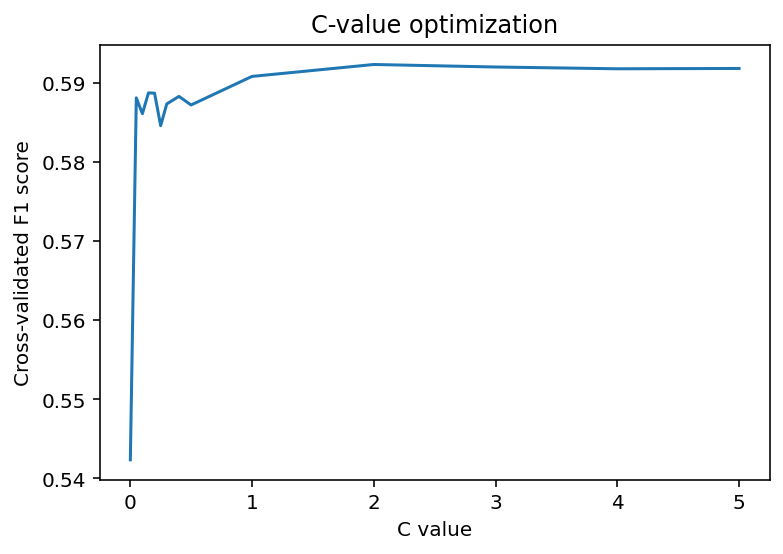

Optimal c-value:  2


In [27]:
from sklearn.linear_model import LogisticRegression

# Define an empty list to store f1scores for different hyperparameters
lr_f1scores = list()

# Values of C to be checked
lr_C_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5]

# Loop over C values to find an optimal
for C_value in lr_C_values:
    
    # Create LogisticRegression object
    lr_foropt = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = C_value, max_iter=1000)
    
    # Fit it to the cross validator
    lr_cv_results_list = cross_val_score(lr_foropt, X, y, cv = split, scoring = 'f1')
    
    # Compute the mean f1_macro score
    lr_avgf1 = np.mean(lr_cv_results_list)
    
    # Append this mean to the list of f1 scores
    lr_f1scores.append(lr_avgf1)
    
# Plot the results
plt.plot(lr_C_values, lr_f1scores)
plt.title('C-value optimization')
plt.ylabel('Cross-validated F1 score')
plt.xlabel('C value')
plt.show()

# Print the value of C-hyperparameter which was found optimal
lr_optimalC = lr_C_values[lr_f1scores.index(max(lr_f1scores))]
print('Optimal c-value: ', lr_optimalC)

# Create logistic regression with our optimal hyperparameter
lr = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = lr_optimalC, max_iter=1000)

### Model 2: Decision Tree Classifier
In this classificator I'll tune 2 hyperparameters: criterion and max_depth of the tree. The instrument for tuning more that 1 hyperparameter is called **Grid Search**, and I apply it here:

In [28]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize a standard classifier
dt_foropt = DecisionTreeClassifier()

# Import GridSearchCV package
from sklearn.model_selection import GridSearchCV

# Instantiate the GridSearchCV object and run the search
parameters_dt = {'criterion':['gini', 'entropy'],
                 'max_depth': np.arange(10,110,10)}

searcher_dt = GridSearchCV(dt_foropt, parameters_dt, cv = split, scoring = 'f1')
searcher_dt.fit(X, y)

# Report the best parameters and the corresponding score
print("Best CV params", searcher_dt.best_params_)

# Initialize a classifier with optimal parameters
dt = DecisionTreeClassifier(criterion = searcher_dt.best_params_['criterion'],
                            max_depth = searcher_dt.best_params_['max_depth'],
                            class_weight = 'balanced')

Best CV params {'criterion': 'entropy', 'max_depth': 10}


### Model 3: KNN Classifier
The key hyperparameter of KNN is K – the number of neighbors to consider in voting.

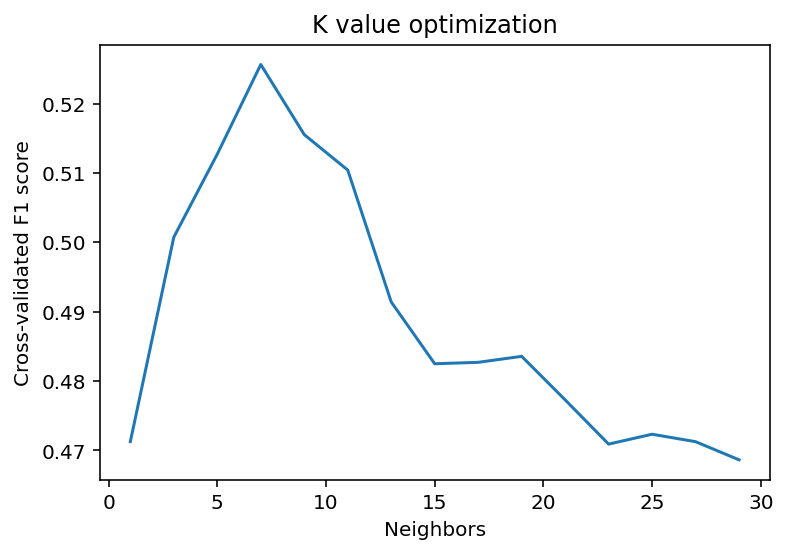

Optimal number of neighbors:  7


In [29]:
# Import KNN from scikit learn
from sklearn.neighbors import KNeighborsClassifier

# Define an empty list to store f1scores for different hyperparameters
knn_f1scores = list()

# Values of K to be checked
neighbors = np.arange(1,30,2)

# Loop over K values to find an optimal
for k in neighbors:
    
    # Create KNeighborsClassifier object
    knn_foropt = KNeighborsClassifier(n_neighbors = k)
    
    # Fit it to the cross validator
    knn_cv_results_list = cross_val_score(knn_foropt, X, y, cv = split, scoring = 'f1')
    
    # Compute the mean f1_macro score
    knn_avgf1 = np.mean(knn_cv_results_list)
    
    # Append this mean to the list of f1 scores
    knn_f1scores.append(knn_avgf1)
    
# Plot the results
plt.plot(neighbors, knn_f1scores)
plt.title('K value optimization')
plt.ylabel('Cross-validated F1 score')
plt.xlabel('Neighbors')
plt.show()

# Print the value of K-hyperparameter which was found optimal
knn_optimal_k = neighbors[knn_f1scores.index(max(knn_f1scores))]
print('Optimal number of neighbors: ', knn_optimal_k)

# Create a model with our optimal hyperparameter
knn = KNeighborsClassifier(n_neighbors = knn_optimal_k)

### Model 4: CatBoost Classifier
CatBoost Classifier is based on decision trees. It's key hyperparameter, according to the documentation, is the regularization strength, called "l2_leaf_reg".

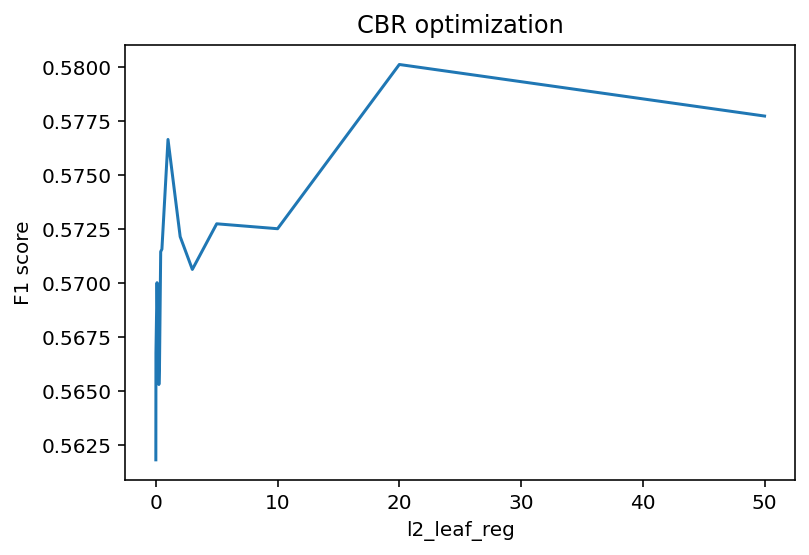

Optimal l2-value:  20


In [30]:
from catboost import CatBoostClassifier

# Define an empty list to store f1scores for different hyperparameters
cbr_f1scores = list()

# Values of l2_leaf_reg to be checked
l2_values = [0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 2, 3, 5, 10, 20, 50]

# Loop over l2_leaf_reg values to find an optimal
for l2 in l2_values:
    
    # Create CatBoostClassifier object
    cbr_foropt = CatBoostClassifier(l2_leaf_reg = l2, silent = True)
    
    # Fit it to the cross validator
    cv_results_list_cbr = cross_val_score(cbr_foropt, X, y, cv = split, scoring = 'f1')
    
    # Compute the mean f1_macro score
    cbr_avgf1 = np.mean(cv_results_list_cbr)
    
    # Append this mean to the list of f1 scores
    cbr_f1scores.append(cbr_avgf1)
    
# Plot the results
plt.plot(l2_values, cbr_f1scores)
plt.title('CBR optimization')
plt.ylabel('F1 score')
plt.xlabel('l2_leaf_reg')
plt.show()

# Print the value of l2-hyperparameter which was found optimal
optimal_l2 = l2_values[cbr_f1scores.index(max(cbr_f1scores))]
print('Optimal l2-value: ', optimal_l2)

# Create CatBoostClassifier with our optimal hyperparameter
cbr = CatBoostClassifier(l2_leaf_reg = optimal_l2, silent = True)

### Model 5. Neural network
I will use a simple neural network from sklearn package.

In [31]:
from sklearn.neural_network import MLPClassifier

"""
There is a rule of thumb for simple networks that the number of nodes in the hidden layer should be half the amount
of features. We will test this, and also the full number of features and the default values from scikit learn - 100.
"""

n_features = len(X.columns)
half = int(n_features / 2)

# Define an empty list to store f1scores for different hyperparameters
nn_f1scores = list()

# Values of combos to be checked
hidden_layer_combos = [(half, half),
                       (n_features, n_features),
                       (half, half, half), 
                       (half, half, half, half, half),
                       (n_features, n_features, n_features),
                       (100),
                       (100,100)]

# Loop over combos to find an optimal
for combo in hidden_layer_combos:
    
    # Create a network object
    nn_foropt = MLPClassifier(hidden_layer_sizes=combo, solver = 'sgd',
                              learning_rate = 'adaptive', early_stopping = True)
    
    # Fit it to the cross validator
    cv_results_list_nn = cross_val_score(nn_foropt, X, y, cv = split, scoring = 'f1_macro')
    
    # Compute the mean f1_macro score
    nn_avgf1 = np.mean(cv_results_list_nn)
    
    # Append this mean to the list of f1 scores
    nn_f1scores.append(nn_avgf1)
    
# Print the value of C-hyperparameter which was found optimal
optimal_combo = hidden_layer_combos[nn_f1scores.index(max(nn_f1scores))]
print('Optimal combo: ', optimal_combo)

# Create a network with our optimal hyperparameter
nn = MLPClassifier(hidden_layer_sizes=optimal_combo, solver = 'sgd',
                   learning_rate = 'adaptive', early_stopping = True)

Optimal combo:  100


## 5. Comparing models

Report for Logistic Regression:
----------------------------------------------------------------------------------------------------


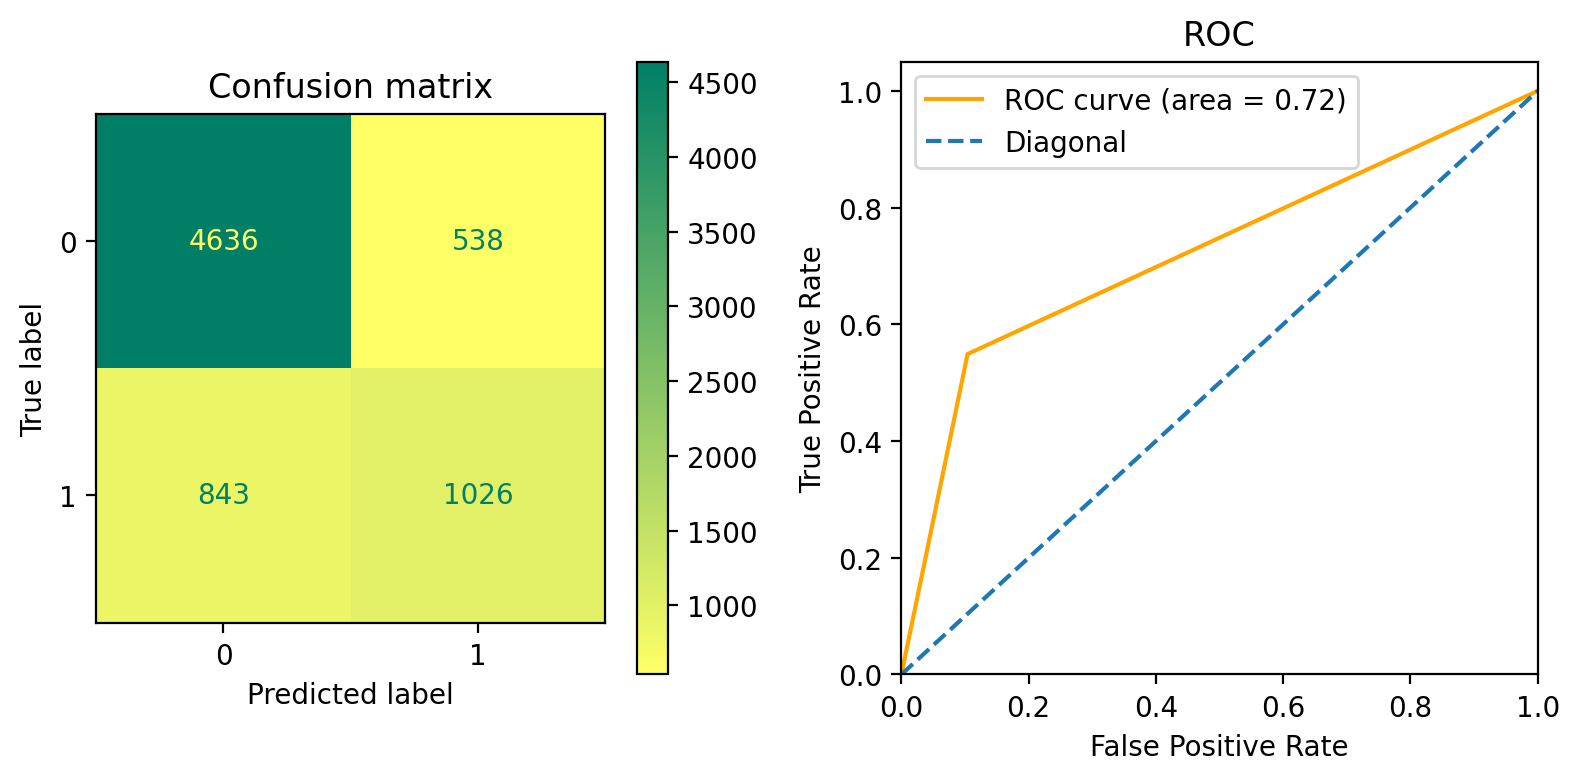

----------------------------------------------------------------------------------------------------
Accuracy:  0.8
Precision:  0.66
Recall:  0.55
F1:  0.6
AUC:  0.72
----------------------------------------------------------------------------------------------------
Report for Decision Tree:
----------------------------------------------------------------------------------------------------


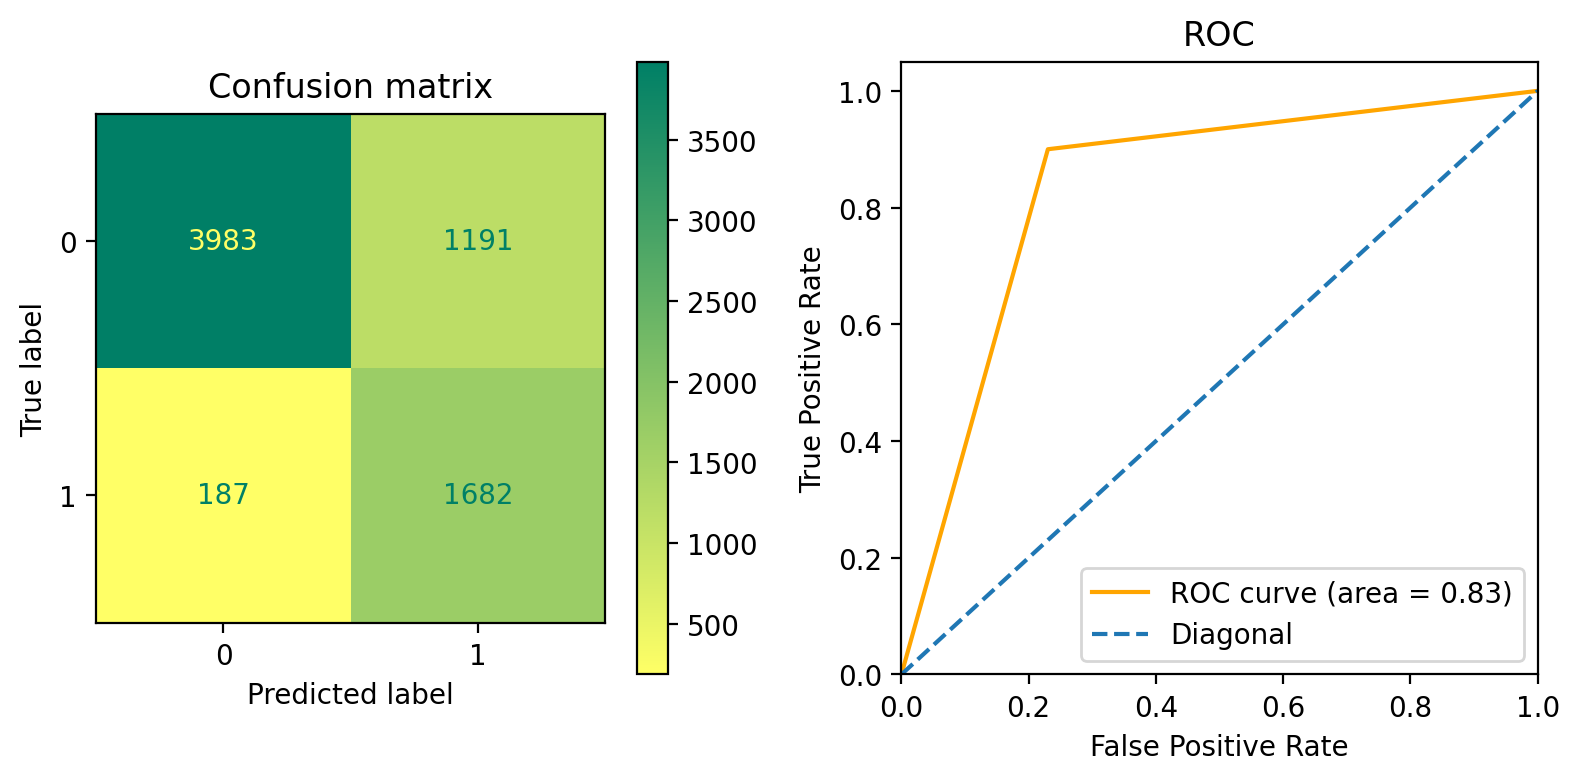

----------------------------------------------------------------------------------------------------
Accuracy:  0.8
Precision:  0.59
Recall:  0.9
F1:  0.71
AUC:  0.83
----------------------------------------------------------------------------------------------------
Report for KNN classifier:
----------------------------------------------------------------------------------------------------


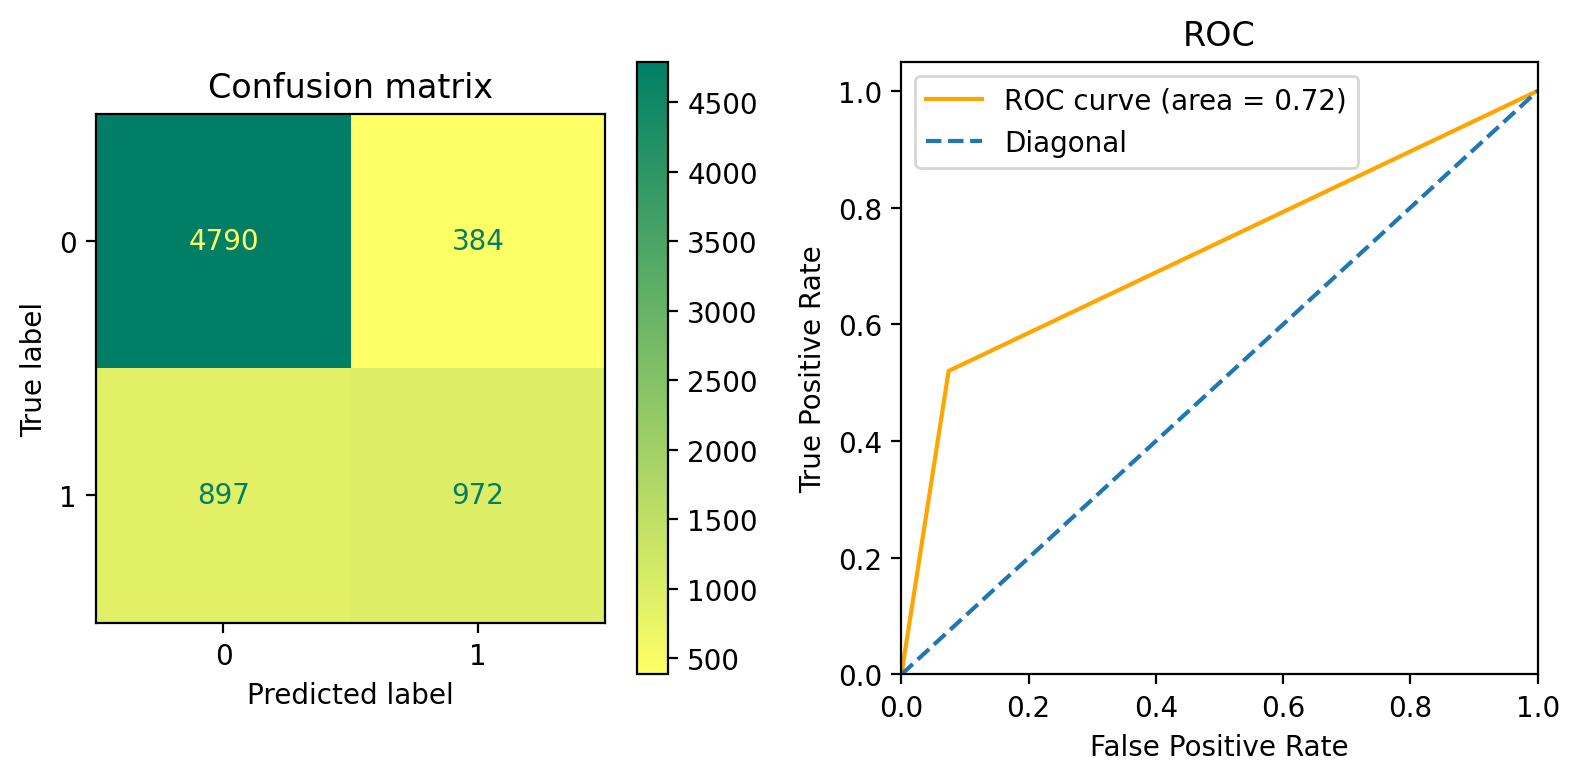

----------------------------------------------------------------------------------------------------
Accuracy:  0.82
Precision:  0.72
Recall:  0.52
F1:  0.6
AUC:  0.72
----------------------------------------------------------------------------------------------------
Report for CatBoost Classifier:
----------------------------------------------------------------------------------------------------


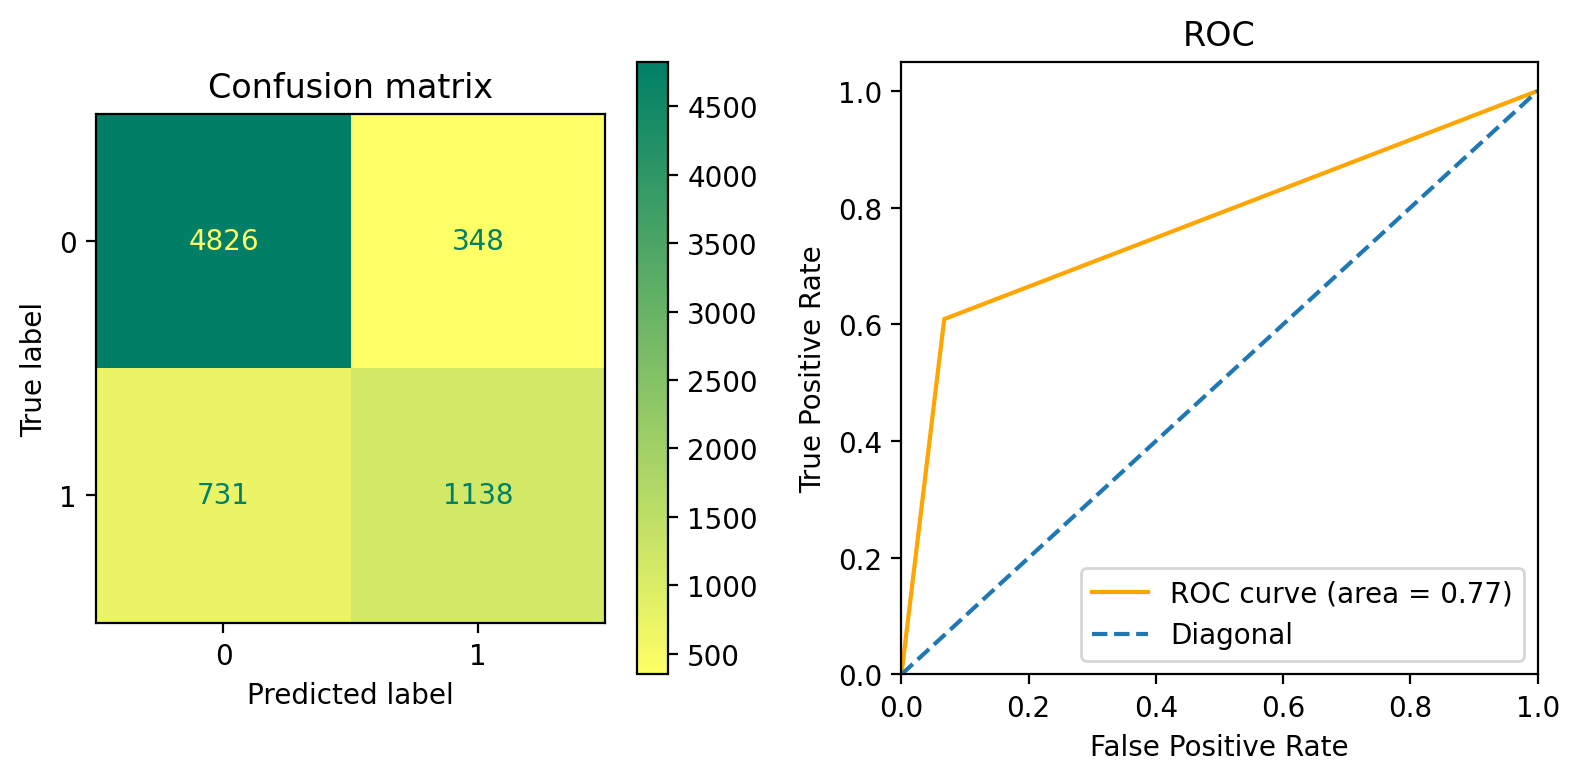

----------------------------------------------------------------------------------------------------
Accuracy:  0.85
Precision:  0.77
Recall:  0.61
F1:  0.68
AUC:  0.77
----------------------------------------------------------------------------------------------------
Report for Neural network:
----------------------------------------------------------------------------------------------------


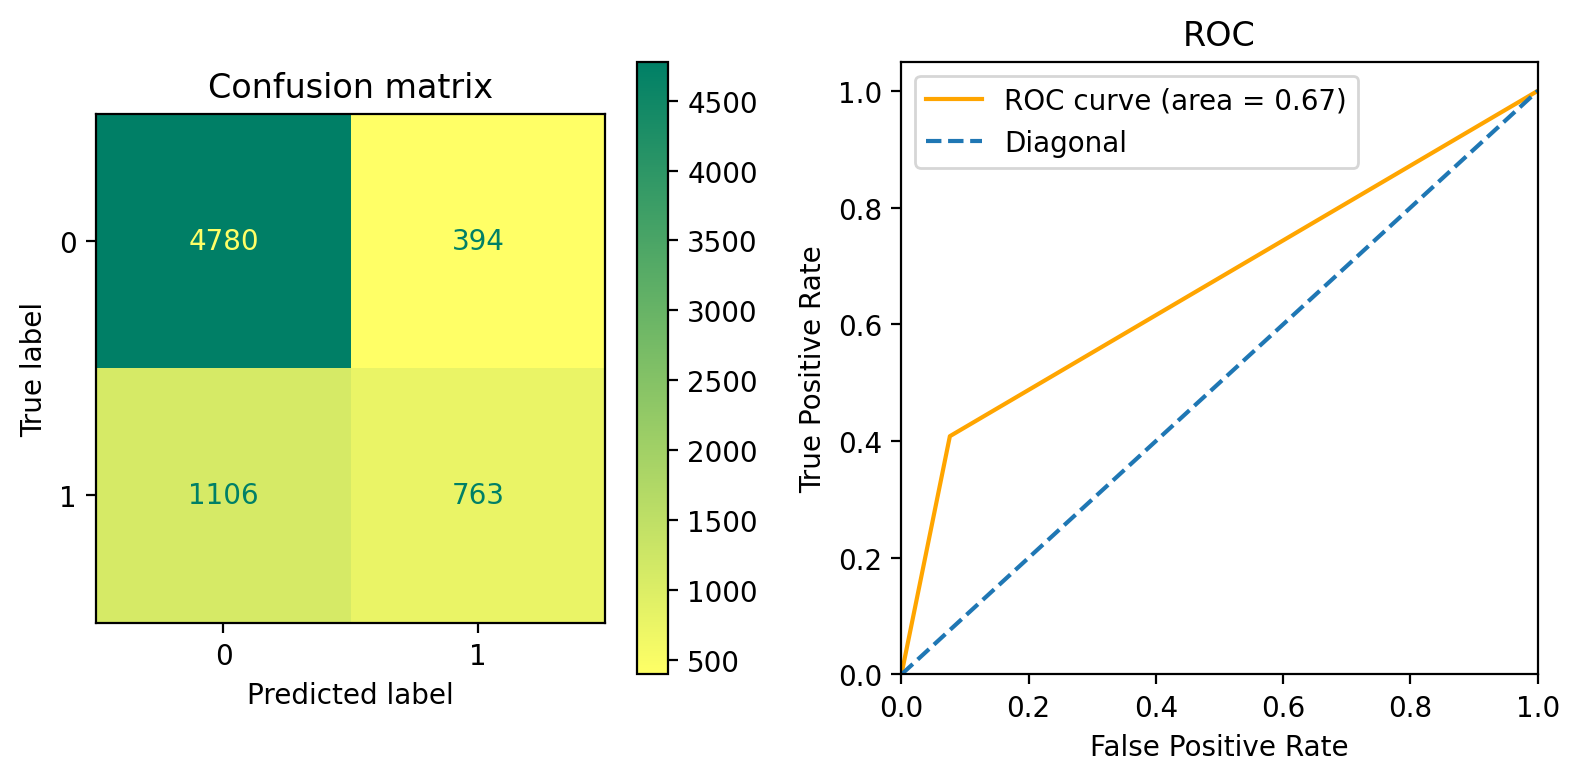

----------------------------------------------------------------------------------------------------
Accuracy:  0.79
Precision:  0.66
Recall:  0.41
F1:  0.5
AUC:  0.67
----------------------------------------------------------------------------------------------------


In [33]:
from sklearn.metrics import plot_confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

def print_report_for_classifier(model, model_name = 'unnamed classifier'):
    """This function takes and UNtrained but created model object and its verbose name as parametets,
    and prints a report with its performance of the entire dataset.
    Please, note, that this report assumes that we test the model on the same data as we use to train it,
    because we've already tuned the hyperparameters in a way to aviod overfitting."""
    
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate necessary data for ROC/AUC
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    area = auc(fpr, tpr)

    print("Report for {}:".format(model_name))
    print('-'*100)
    
    # The next block of code just creates a figure with 2 charts
    fig = plt.figure(figsize = (8, 4), dpi = 100)

    axes11 = fig.add_subplot(121)
    plot_confusion_matrix(model, X, y, cmap = 'summer_r', values_format = "1", ax = axes11)
    axes11.set_title('Confusion matrix')

    axes12 = fig.add_subplot(122)
    axes12.plot(fpr, tpr, color = 'orange', label = "ROC curve (area = {:.2f})".format(area))
    axes12.plot([0,1], [0,1], linestyle='--', label = 'Diagonal')
    axes12.set_xlim([0,1])
    axes12.set_ylim([0,1.05])
    axes12.set_xlabel('False Positive Rate')
    axes12.set_ylabel('True Positive Rate')
    axes12.set_title('ROC')
    axes12.legend()

    plt.tight_layout()
    plt.show()
    print('-'*100)
    
    # We include 4 key metrics in our report
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1: ', round(f1, 2))
    print('AUC: ', round(area, 2))
    print('-'*100)

print_report_for_classifier(lr, 'Logistic Regression')
print_report_for_classifier(dt, 'Decision Tree')
print_report_for_classifier(knn, 'KNN classifier')
print_report_for_classifier(cbr, 'CatBoost Classifier')
print_report_for_classifier(nn, 'Neural network')

## 6. Making conclusions
According to our criteria – F1 score, the best model is Decision tree. It gives us the best trade-off between precision and recall. However, I’d like to highlight to details:

- Decision tree also has the highest recall – 0.9. It means that while ensuring the best trade-off between precision and recall, it is also the best from the perspective of not missing customers which are likely to churn.
- On the other hand, CatBoost model has a bit worse F1 score, but significantly higher precision. It means that this model is the most conservative one – out of all churn predictions, only 23% are wrong.

Let’s imagine an anonymous telecom company which has a dataset in the format of the one I used, it preprocesses it the same way and has 5 identical models, in terms of hyperparameters.
My conclusion is the following. It should apply: 

- Decision tree, if it has access to cheap marketing instruments, for example massive SMS mailing or large call center.
- CatBoost, if it is limited in funds, and wants to reach less customers, but be more precise in those who are really likely to churn.